1. Libraries


In [ ]:

# Installing libraries
using Pkg

Pkg.add("JuMP")
Pkg.add("Gurobi")
Pkg.add("CSV")
Pkg.add("XLSX")
Pkg.add("DataFrames")
Pkg.add("Plots")
Pkg.add("GLPK")

# Load libraries
using JuMP, Gurobi, CSV, XLSX, DataFrames, Plots


2. Read/Import the Generated Data

In [2]:

# Read the data from the CSV file
data = CSV.read("my_data.csv", DataFrame)

# Access the columns from the read DataFrame
criti = data.criti      # criticality
labels = data.labels    # labels or load type
pawar = data.pawar      # power rating
start_time = data.start_time   # appliance start_time
end_time = data.end_time       # appliance end_time
d = data.d                     # duration of operation

println("\nData read from $data:")



Data read from 10×6 DataFrame
 Row │ criti  labels   pawar    start_time  end_time  d
     │ Int64  String7  Float64  Int64       Int64     Int64
─────┼──────────────────────────────────────────────────────
   1 │   601  NSNI         0.6           2         3      1
   2 │   326  SI           0.9           5        11      2
   3 │    22  SI           1.5           6        11      4
   4 │   379  NSNI         1.2           8        12      4
   5 │   751  NSNI         0.5           6         7      1
   6 │    41  SI           1.1          12        18      2
   7 │    46  SNI          1.2          12        19      1
   8 │   600  SI           0.5          13        19      2
   9 │   818  SNI          0.6          20        23      1
  10 │    58  SNI          1.1          19        23      2:


3. Complete Model Implementation

In [3]:
using JuMP, CSV, XLSX, DataFrames, Plots, Gurobi


# Data and variables for appliances

# Data for the solar plant 6kW (8.55kWh/day), Brookings OCT 12, 2019,  from renewable energy ninja: https://www.renewables.ninja/
P_PV = [0, 0, 0, 0, 0, 0, 0.101, 0.544, 0.973, 1.393, 1.43, 1.361, 1.365, 1.152, 0.682, 0.292, 0.066, 0, 0, 0, 0, 0, 0, 0] # data read from csv file

C = criti
appliance_names = labels
power = pawar

L = length(appliance_names)  # Number of loads i.e. 10
T = 24  # Total time, 24 hours

# Constants and Assumptions
λ = 0.2
E_total = 3.5               # Battery capacity in kWh
SOC_min = 0.1 * E_total     # Minimum SOC
SOC_max = 0.9 * E_total     # Maximum SOC
ηc = 0.95                   # Charging efficiency
ηd = 0.95                   # Discharging efficiency
initial_SOC = 0.8 * E_total # Initial SOC (80% of E_total)
final_SOC = 0.2 * E_total   # Final SOC (20% of E_total)

# Power limits
Pbc_max = 1.0   # Max charging power in kW
Pbc_min = 0.0   # Min charging power in kW
Pbd_max = -1.0  # Max discharging power in kW
Pbd_min = 0.0   # Min discharging power in kW
times = 1:T

# Create model
model = Model(Gurobi.Optimizer)

# Decision variables
@variable(model, x[1:L, 1:T], Bin)  # Binary decision variable for appliances
@variable(model, y[1:L, 1:T], Bin)  # Auxiliary binary variable for non-interruptible devices

@variable(model, P_bc[1:T])             # Charging power, battery
@variable(model, P_bd[1:T])             # Discharging power, battery

@variable(model, P_curtail[1:T])        # Curtailed power
@variable(model, SOC[1:T])              # State of charge

@variable(model, Bc[1:T], Bin)          # Binary charging status
@variable(model, Bd[1:T], Bin)          # Binary discharging status

@variable(model, skip[i=1:L], Bin)      # Binary variable for skipping appliance,


# Objective function: Maximize served load and minimize curtailment
@objective(model, Max, 
    sum(C[i] * x[i, t] for i in 1:L for t in 1:T) - 0.2 * sum(P_curtail[t] for t in 1:T)
)

# Power balance equaton
for t in 1:T
    @constraint(model, sum(power[i] * x[i, t] for i in 1:L) + P_bc[t] * Bc[t] + P_curtail[t] == P_PV[t] - P_bd[t] * Bd[t] )
end

# SOC estimation
for t in 1:T
    if t == 1
        # Initial SOC, when t is 1
        @constraint(model, SOC[t] == initial_SOC + (ηc * P_bc[t] * Bc[t] + (P_bd[t] * Bd[t])/ ηd)/E_total)
    else
        # consider this equation for SOC update when t > 1
        @constraint(model, SOC[t] == SOC[t - 1] + (ηc * P_bc[t] * Bc[t] + (P_bd[t] * Bd[t])/ ηd)/E_total)
    end
end

# Battery charging limits
@constraint(model, [t in 1:T], Pbc_min <= P_bc[t] <= Pbc_max)

# Battery discharging power limits
@constraint(model, [t in 1:T], Pbd_min >= P_bd[t] >= Pbd_max)

# SOC bounds 
@constraint(model, [t in 1:T], SOC_min <= SOC[t] <= SOC_max)

# Stop simultaneous charging and discharging
for t in 1:T
    @constraint(model, Bc[t] + Bd[t] <= 1)
end

# Final SOC constraint
@constraint(model, SOC[T] >= final_SOC)

# Power Curtailment constraint, need to modify it
@constraint(model, [t in 1:T], P_curtail[t] >= 0)


# Loads Category and Opteration

# 1. SI Devices (Schedulable and Interruptible)
# For all SI devices
si_indices = findall(x -> x == "SI", appliance_names)

# SI devices' constraint
for i in si_indices
    @constraint(model, sum(x[i, t] for t in 1:T) == (1 - skip[i]) * d[i])
    for t in 1:T
        if t < start_time[i] || t >= end_time[i]  # Appliance cannot operate before its allowed time window
            @constraint(model, x[i, t] == 0)  # Cannot operate after allowed time window
        end
    end
end

# 2. SNI devices (schedulable and non-interruptible)
# For all SNI devices
sni_indices = findall(x -> x == "SNI", appliance_names) 

for i in sni_indices
    for t in 1:T
        # Constraint for non-interruptibility (can’t turn off once started)
        @constraint(model, x[i, t] <= 1 - y[i, t])
    end
    for t in 2:T
        # Manage transitions
        @constraint(model, x[i, t - 1] - x[i, t] <= y[i, t])
        # for consistency in transitions
        @constraint(model, y[i, t - 1] <= y[i, t])
    end
    @constraint(model, sum(x[i, t] for t in 1:T) == (1 - skip[i]) * d[i])

    for t in 1:T
        # Appliance cannot operate before its allowed time window
        if t < start_time[i] || t >= end_time[i]
            @constraint(model, x[i, t] == 0)  # Cannot operate after allowed time window
        end
    end
end

# 3. NSNI loads (non-schedulable and non-interruptible)
# For all NSNI devices
nsni_indices = findall(x -> x == "NSNI", appliance_names)

for i in nsni_indices
    for t in 1:T
        # Ensure device operates only for the specified time 
        if t >= start_time[i] && t < start_time[i] + d[i]
            @constraint(model, x[i, t] <= 1 - skip[i])
        else
            # Load must be inactive outside the fixed/specified duration
            @constraint(model, x[i, t] == 0)
        end
    end
    # Run from start to end time
    @constraint(model, sum(x[i, t] for t in start_time[i]:(start_time[i] + d[i] - 1)) == (1 - skip[i]) * d[i])
end

# Solve the optimization problem
optimize!(model)


# Extract and display results
SOC_results = value.(SOC)
P_bc_results = value.(P_bc)
P_bd_results = value.(P_bd)
load_served = [sum(value(x[i, t]) for i in 1:L) for t in times]
P_curtailed = [sum(value(P_curtail[t]) for i in 1:L) for t in times]

# print the output
println("SOC : ", SOC_results)
println("Charging power values (P_bc): ", P_bc_results)
println("Discharging power (P_bd): ", P_bd_results)
println("Load Served: ", load_served)
println("Power Curtailed: ", P_curtailed)

Set parameter Username
Set parameter LicenseID to value 2586663
Academic license - for non-commercial use only - expires 2025-11-18
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) i7-14700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 28 logical processors, using up to 28 threads

Optimize a model with 544 rows, 706 columns and 1099 nonzeros
Model fingerprint: 0xe0b13926
Model has 48 quadratic constraints
Variable types: 168 continuous, 538 integer (538 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+00]
  QMatrix range    [3e-01, 1e+00]
  QLMatrix range   [5e-01, 2e+00]
  Objective range  [2e-01, 8e+02]
  Bounds range     [4e-01, 3e+00]
  RHS range        [7e-01, 4e+00]
  QRHS range       [7e-02, 3e+00]
Presolve removed 515 rows and 531 columns
Presolve time: 0.00s
Presolved: 221 rows, 223 columns, 610 nonzeros
Variable types: 144 continuous, 79 integer (79 binary)
Found heuristic solutio

Appliance scheduling plot based on criticality

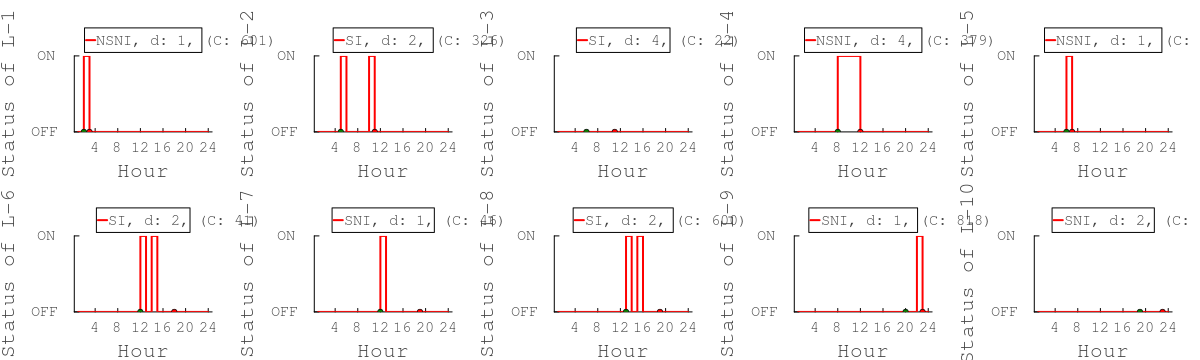

GKS: could not find font Times New Roman.ttf


In [4]:
using Plots

# Times New Roman font
default(fontfamily="Times New Roman")
output_matrix = [value(x[i, t]) for i in 1:L, t in 1:T]  # binary results from  above simulated model

num_rows = 2
# Initialize subplots
plot_list = []

for i in 1:L
    # Binary load operation
    shifted_rect = [output_matrix[i, t] == 1 ? 1.0 : 0.0 for t in 1:T]

    # Individual appliance plot
    p = plot(1:T, shifted_rect,
        label="$(appliance_names[i]), d: $(d[i]), (C: $(C[i]))",
        lw=2,
        color=:red,
        xlabel="Hour",
        ylabel="Status of L-$(i)",
        # left_margin = 6mm,
        grid=false,
        ylims=(0, 1),
        yticks=([0, 1],["OFF", "ON"]),
        xticks=0:4:24,
        seriestype=:step,
        margin=20Plots.px,
        legend=:topleft,
        fontfamily="Times New Roman",
        fontsize=12,
        titlevisible=false
    )

    # Shift the y-label 
    plot!(p, yguideoffset=-200)

    # Start and End markers
    scatter!(p, [start_time[i]], [0], color=:green, marker=:circle, ms=3, label="")
    scatter!(p, [end_time[i]], [0], color=:red, marker=:circle, ms=3, label="")

    push!(plot_list, p)
end

num_cols = ceil(Int, length(plot_list) / num_rows)

# Arrange all subplots
final_plot = plot(plot_list...,
    layout=(num_rows, num_cols),
    size=(1200, 180 * num_rows),
    margin=20Plots.px,
    legend=:outertop,
    fontfamily="Times New Roman",
    fontsize=12
)

# legend titles
for i in 1:length(plot_list)
    plot!(plot_list[i], legendtitle="L$(i)", legend=true)
end

# Save and display
savefig(final_plot, "scheduling_results.pdf")
display(final_plot)

Operation of Battery Charging, Discharging, Load Served, P-curtail, and Solar Power

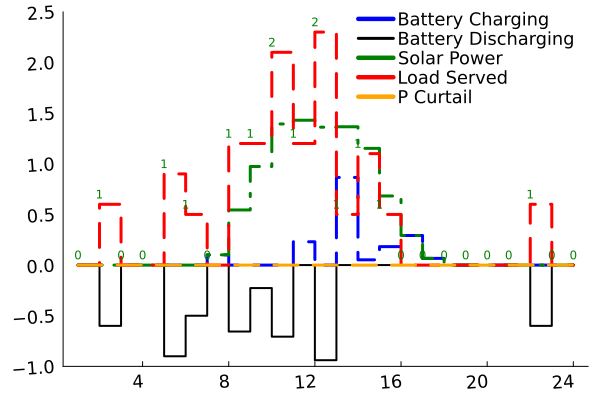

In [5]:

using Plots

fontsize = 12

# Extract values
battery_charge = [value(P_bc[t]) for t in times]
battery_discharge = [value(P_bd[t]) for t in times]
solar_power = [P_PV[t] for t in times]
load_served = [sum(value(x[i, t]) * power[i] for i in 1:L) for t in times]

# Calculate the number of loads that are "on" and round to whole numbers
loads_on_count = [round(Int, sum(value(x[i, t]) for i in 1:L)) for t in times]

# P Curtail
P_curtaill = [value(P_curtail[t]) for t in times]

# 
p1 = plot(
    times, battery_charge,
    seriestype=:steppost,
    size=(600, 200 * num_rows), 
    fontsize=18,
    label="Battery Charging",
    color=:blue,
    linewidth=2,
    linestyle=:dash,
    grid=false,
    lw=3,
    # legend=:topright,
    guidefont=font(fontsize),
    tickfont=font(fontsize),
    fg_legend =:Transparent,
    legend_background_color=:transparent,  # Set the legend background to transparent
    legend_bordercolor=:transparent,  
    y_guidefontcolor=:black,
    y_foreground_color_axis=:transparent,
    y_foreground_color_text=:transparent,
    ytickfontcolor=:black,
    xticks=0:4:24,
    ylims=[-1, 2.5],
    legendfont=font(12),
    xaxis=(linewidth=4),
    yaxis=(linewidth=4),
    legend_position= (0.64, 0.98)
)
plot!(times, battery_discharge, seriestype=:steppost, label="Battery Discharging", color=:black, linewidth=2)
plot!(times, solar_power, seriestype=:steppost, label="Solar Power", color=:green, linewidth=3, linestyle=:dashdot)
plot!(times, load_served, seriestype=:steppost, label="Load Served", color=:red, linewidth=3, linestyle=:dash)
plot!(times, P_curtaill, seriestype=:steppost, label="P Curtail", color=:orange, linewidth=3, linestyle=:dash)

# Cap values for loads ON 
for t in times
    annotate!(t, load_served[t] + 0.1, text(string(loads_on_count[t]), :green, 8, :center))
end

# Save
savefig("IEEE_FORMAT battery_solar_load_step_latest.pdf")

# Display
display(p1)


Battery Charging, Discharging and SOC over Time

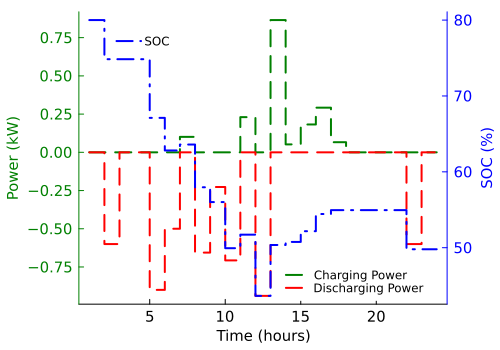

┌ Warning: Skipped yaxis arg right
└ @ Plots C:\Users\arshid.ali\.julia\packages\Plots\MR7sb\src\axes.jl:76


In [6]:
using DataFrames, Plots

# Define the given SOC data
SOC = value.(SOC) 

# Calculate battery charging and discharging power
battery_charge = [value(P_bc[t]) for t in times] 
battery_discharge = [value(P_bd[t]) for t in times]

SOC_results= SOC
P_bc_results= battery_charge
P_bd_results = battery_discharge

# Convert SOC to percentage
SOC_percentage = [(soc / 3.5) * 100 for soc in SOC_results] 
time_steps = 1:length(SOC_results)

# Create DataFrames
df_soc = DataFrame(Time=time_steps, SOC_Percentage=SOC_percentage)
df_power = DataFrame(Time=time_steps, ChargingPower=P_bc_results, DischargingPower=P_bd_results)

# Plot settings
fontsize = 10  # Font size
figsize = (500, 350)

# left y-axis for charging/discharging power
p = plot(
    df_power.Time, df_power.ChargingPower,
    seriestype = :steppost,
    xlabel = "Time (hours)",
    ylabel = "Power (kW)",
    label = "Charging Power",
    lw = 2,
    linecolor = :green,
    grid = :y,
    # legend = :topright,
    fg_legend=:Transparent,

    size = figsize,
    guidefont = font(fontsize),
    tickfont = font(fontsize),
    legend_position= (0.64, 0.1), # custom legend
    legendfont = font(8),
    y_guidefontcolor=:green,
    y_foreground_color_axis=:green,
    y_foreground_color_text=:green,
    ytickfontcolor=:green,
    linestyle = :dash,
    y_foreground_color_border=:green,
)

plot!(
    p,
    df_power.Time, df_power.DischargingPower,
    seriestype = :steppost,
    label = "Discharging Power",
    lw = 2,
    linecolor = :red,
    linestyle = :dash,
)

# twinx plot to add a secondary y-axis for SOC percentage, double y-axis plot
ax2 = twinx()
plot!(
    ax2,
    df_soc.Time, df_soc.SOC_Percentage,
    seriestype = :steppost,
    yaxis = :right,
    ylabel = "SOC (%)",
    label = "SOC",
    lw = 2,
    linecolor = :blue,
    # legend = :bottomright,
    fg_legend=:Transparent,
    legend_position= (0.18, 0.9),
    guidefont = font(fontsize),
    tickfont = font(fontsize),
    y_guidefontcolor=:blue,
    y_foreground_color_axis=:blue,
    y_foreground_color_text=:blue,
    ytickfontcolor=:blue,
    linestyle = :dashdot,
    y_foreground_color_border=:blue,
    legendfont = font(8),
)

# Save and display the plot
savefig("battery_charge_discharge_and_soc_plot.pdf")
display(p)


Find the total load and criticality

In [7]:
using DataFrames

load_served = [sum(value(x[i, t]) * power[i] for i in 1:L) for t in times]  # Power scheduled for loads that are Turned-ON

# Create a DataFrame
d = DataFrame(
    Time = times,
    LoadPowerServed = load_served
)

# Print the DataFrame
println(d)


# Calculate cumulative criticality
cumulative_criticality = [sum(C[i] * value(x[i, t]) for i in 1:L) for t in times]

# Create a DataFrame
df = DataFrame(
    Time = times,
    Criticality = cumulative_criticality
)

# Print the DataFrame
println(df)
df


24×2 DataFrame
 Row │ Time   LoadPowerServed 
     │ Int64  Float64         
─────┼────────────────────────
   1 │     1              0.0
   2 │     2              0.6
   3 │     3              0.0
   4 │     4              0.0
   5 │     5              0.9
   6 │     6              0.5
   7 │     7              0.0
   8 │     8              1.2
   9 │     9              1.2
  10 │    10              2.1
  11 │    11              1.2
  12 │    12              2.3
  13 │    13              0.5
  14 │    14              1.1
  15 │    15              0.5
  16 │    16              0.0
  17 │    17              0.0
  18 │    18              0.0
  19 │    19              0.0
  20 │    20              0.0
  21 │    21              0.0
  22 │    22              0.6
  23 │    23              0.0
  24 │    24              0.0
24×2 DataFrame
 Row │ Time   Criticality 
     │ Int64  Float64     
─────┼────────────────────
   1 │     1          0.0
   2 │     2        601.0
   3 │     3          0.

Row,Time,Criticality
,Int64,Float64
1,1,0.0
2,2,601.0
3,3,0.0
4,4,0.0
5,5,326.0
6,6,751.0
7,7,0.0
8,8,379.0
9,9,379.0


Use/Plot the Served Loads' Commulative  Criticality and Energy Consumption

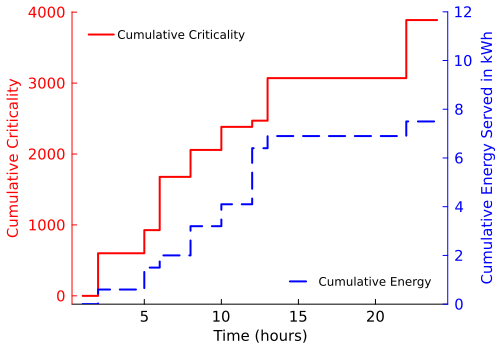

┌ Warning: Skipped yaxis arg right
└ @ Plots C:\Users\arshid.ali\.julia\packages\Plots\MR7sb\src\axes.jl:76


In [8]:
using DataFrames, Plots

# Create the Criticality DataFrame
df_criticality = DataFrame(
    Row = 1:24,
    Time = 1:24,
    Criticality = [0.0, 601.0, 0.0, 0.0, 326.0, 751.0, 0.0, 379.0, 0.0, 326.0, 0.0, 87.0, 600.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 818.0, 0.0, 0.0]
)

# Calculate cumulative criticality
df_criticality.CumulativeCriticality = cumsum(df_criticality.Criticality)

# Create the Load Power Served DataFrame
df_load = DataFrame(
    Row = 1:24,
    Time = 1:24,
    LoadPowerServed = [0.0, 0.6, 0.0, 0.0, 0.9, 0.5, 0.0, 1.2, 0.0, 0.9, 0.0, 2.3, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0]
)
# Calculate cumulative load power served
df_load.CumulativeLoadPowerServed = cumsum(df_load.LoadPowerServed)

# Plot settings
fontsize = 10  
figsize = (500, 350)  

p = plot(
    df_criticality.Time, df_criticality.CumulativeCriticality,
    seriestype = :steppost,
    xlabel = "Time (hours)",
    ylabel = "Cumulative Criticality",
    label = "Cumulative Criticality", 
    lw = 2,
    linecolor = :red,
    grid = :y,
    legend = :topleft,
    size = figsize,
    fg_legend=:Transparent,

    guidefont = font(fontsize),
    tickfont = font(fontsize),
    legendfont = font(8),
    y_guidefontcolor=:red,
    y_foreground_color_axis=:red,
    y_foreground_color_text=:red,
    ytickfontcolor=:red,
    # linestyle=:dashdot,
    y_foreground_color_border=:red,)
# Add a secondary y-axis plot using twinx()
ax2 = twinx()
plot!(
    ax2,
    df_load.Time, df_load.CumulativeLoadPowerServed,
    seriestype = :steppost,
    yaxis = :right,
    ylabel = "Cumulative Energy Served in kWh",
    label = "Cumulative Energy",
    ylims=(0, 12),
    lw = 2,
    linecolor = :blue,
    legend = :bottomright,
    guidefont = font(fontsize),
    fg_legend=:Transparent,
    tickfont = font(fontsize),
    y_guidefontcolor=:blue,
    y_foreground_color_axis=:blue,
    y_foreground_color_text=:blue,
    ytickfontcolor=:blue,
    linestyle=:dash,
    y_foreground_color_border=:blue,
    legendfont = font(8)
)


# Save the plot
savefig("Commulative_Criticality_Load_plt.pdf")
savefig("Commulative_Criticality_Load_plt.svg")

display(p)